In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your files
ed_visits = pd.read_csv("C://Users//shoaib//Desktop//New folder//Cleaned_dataset//pho_ed_visits_phu_month_2014-2024.csv.csv")
onmarg = pd.read_csv("C://Users//shoaib//Desktop//New folder//Cleaned_dataset//onmarg_phu_static_2021.csv.csv")



In [13]:
ed_visits.columns = ed_visits.columns.str.strip().str.lower()
onmarg.columns = onmarg.columns.str.strip().str.lower()



In [15]:
substance_indicators = [
    "ED visits due to opioid-related poisonings",
    "Deaths due to opioid toxicity",
    "Deaths due to opioid toxicity (with stimulant involvement)",
    "Deaths due to opioid toxicity (with benzodiazepine involvement)",
    "Deaths due to stimulant toxicity",
    "Deaths due to stimulant toxicity (without opioid involvement)",
    "Deaths due to benzodiazepine toxicity",
    "Deaths due to benzodiazepine toxicity (without opioid involvement)"
]

# Keep only ED visit records (drop "Deaths" if you only want ED visits)
ed_filtered = ed_visits[
    ed_visits['indicator'].isin(["ED visits due to opioid-related poisonings"])
].copy()



In [17]:
ed_filtered['start_date_of_time_period'] = pd.to_datetime(ed_filtered['start_date_of_time_period'], errors='coerce')
ed_filtered['year'] = ed_filtered['start_date_of_time_period'].dt.year

# Group by PHU and year
annual_ed = (
    ed_filtered.groupby(['public_health_unit', 'year'])
    .agg({'number_of_cases': 'sum', 'population': 'mean'})
    .reset_index()
)

annual_ed['cases_per_100k'] = (annual_ed['number_of_cases'] / annual_ed['population']) * 100000



In [19]:
# Standardize names for merging
onmarg['hu_name'] = onmarg['hu_name'].str.strip().str.lower()
annual_ed['phu_name_clean'] = annual_ed['public_health_unit'].str.strip().str.lower()

# Merge
merged = pd.merge(
    annual_ed,
    onmarg,
    left_on='phu_name_clean',
    right_on='hu_name',
    how='left'
)

print("Unmatched PHUs:", merged['huid'].isna().sum())


Unmatched PHUs: 242


C:\Users\shoaib\AppData\Local\Temp\ipykernel_41740\282149785.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=phu_avg.values, y=phu_avg.index, palette='flare')


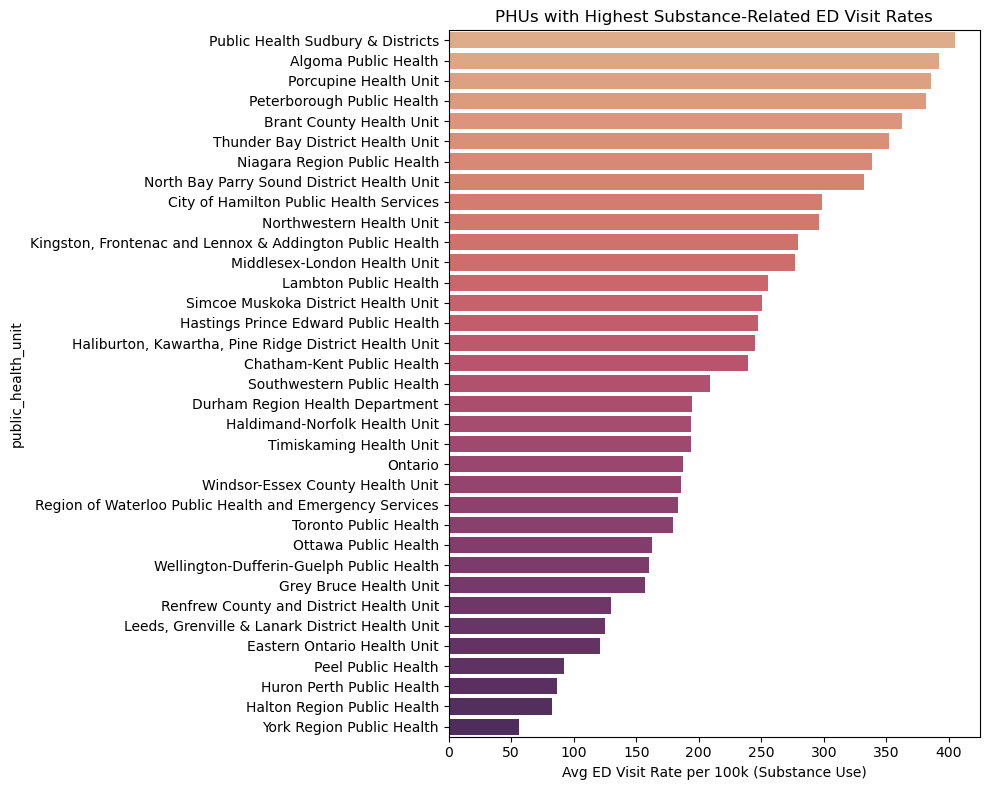

In [21]:
phu_avg = merged.groupby('public_health_unit')['cases_per_100k'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=phu_avg.values, y=phu_avg.index, palette='flare')
plt.xlabel("Avg ED Visit Rate per 100k (Substance Use)")
plt.title("PHUs with Highest Substance-Related ED Visit Rates")
plt.tight_layout()
plt.show()



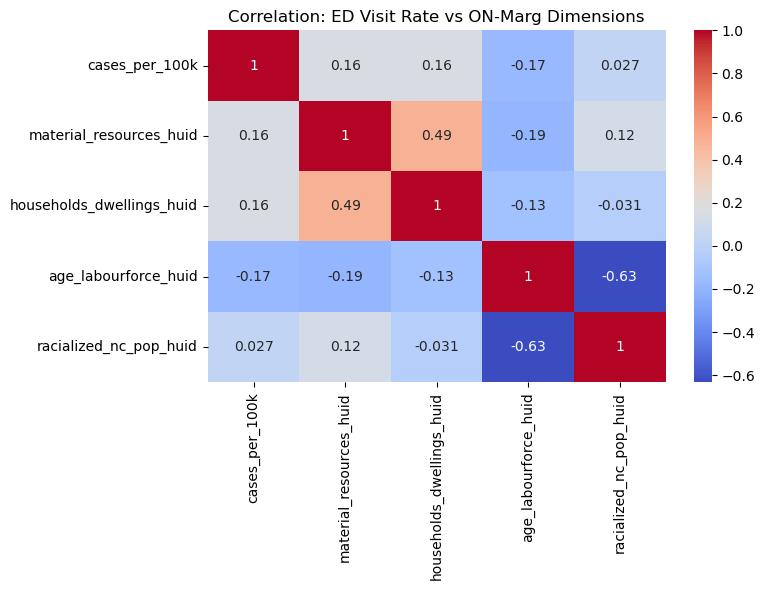

In [23]:
# Select variables for correlation
corr_df = merged[[
    'cases_per_100k',
    'material_resources_huid',
    'households_dwellings_huid',
    'age_labourforce_huid',
    'racialized_nc_pop_huid'
]].dropna()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation: ED Visit Rate vs ON-Marg Dimensions")
plt.tight_layout()
plt.show()


In [27]:
import seaborn as sns
import statsmodels.api as sm
X = corr_df.drop(columns='cases_per_100k')
X = sm.add_constant(X)
y = corr_df['cases_per_100k']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         cases_per_100k   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     2.231
Date:                Thu, 17 Jul 2025   Prob (F-statistic):             0.0688
Time:                        19:51:42   Log-Likelihood:                -926.24
No. Observations:                 143   AIC:                             1862.
Df Residuals:                     138   BIC:                             1877.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 